# Vision Transformer Study
- code is from insightface > backbones > vit.py

In [1]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from typing import Optional, Callable

/home/dmsl9/anaconda3/envs/vit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MLP

In [2]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.ReLU6, drop=0. ):
        super(Mlp,self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        # layers
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


## ViT BatchNorm

In [3]:
class VITBatchNorm(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm1d(num_features=num_features)
    
    def forward(self,x):
        return self.bn(x)

## Attention
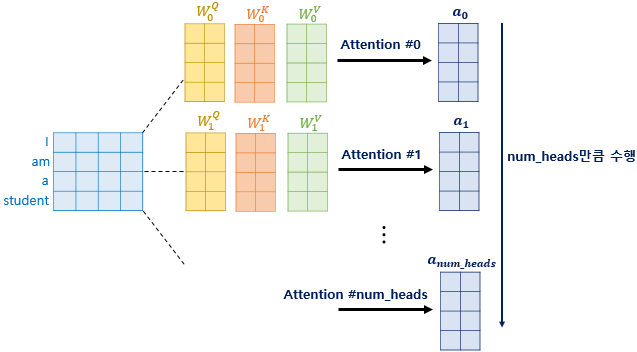
        
        | Embbeding된 벡터들은 -> [num_features, embedding_dimension=512]로 저장됨 (예를 들어서 8개의 이미지 패치 -> [8,512])

### Multi-head Attention
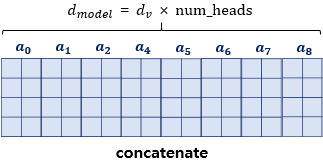

        | 그렇게 어려운 개념은 아님. 임베딩된 벡터를 하나의 FCL로 attention을 구하는게 아니라, 여러개로 나누고, 나중에 concat하는거임.
        num_heads(hp) * head_dimension = embedding_dimension(512)
        - hp (hyper-parameter)
        embedding_dimension(input)과 ouput의 dimension을 동일하게 유지하기 위해, num_heads만 정해주면 됨


***@*** : Matix Mutliplcation

In [4]:
class Attention(nn.Module):
    def __init__(self,
                 dim : int, # default = embed_dim = 768 (16 * 16 * 3)
                 num_heads: int = 8,
                 qkv_bias:bool = False,
                 qk_scale: Optional[None] = None,
                 attn_drop:float = 0.,
                 proj_drop:float = 0.):
        super().__init__()

        # for Multi head
        # Head의 개수 = embed_dimension // Head dimension
        self.num_heads = num_heads #8
        head_dim = dim // num_heads # 96 

        # Query Key Scale -> Attension Score에 Scale 곱해서 사용하는듯
        self.scale = qk_scale or head_dim ** -0.5

        # query key value 한번에 
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias) # (768, 768*3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim) # for projection?
        self.proj_drop = nn.Dropout(proj_drop)
    
    def forward(self, x):
        with torch.cuda.amp.autocast(True):
           
            batch_size ,num_token, embed_dim = x.shape
            # x : []
            # qkv -> [3(query,key,value), batch_size, num_heads, num_token, embed_dim//num_heads]
            qkv = self.qkv(x).reshape(
                batch_size, num_token, 3, self.num_heads, embed_dim // self.num_heads
            ).permute(2,0,3,1,4)

        with torch.cuda.amp.autocast(False):
            q, k, v = qkv[0].float(), qkv[1].float(), qkv[2].float()
            attn = (q @ k.transpose(-2, -1)) * self.scale 
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = (attn @ v).transpose(1,2).reshape(batch_size, num_token, embed_dim)
        
        with torch.cuda.amp.autocast(True):
            x = self.proj(x)
            x = self.proj_drop(x)
        
        return x



### Block

<br/>하나의 Block으로, ViT에서 여러개의 블럭을 사용함
<br/> 하나의 블럭에서는 input -> norm1 -> MHA(multi-head Att) -> (drop_path + residual) -> norm2 -> mlp -> (drop_path + residual)

#### [DropPath VS Dropout](https://stackoverflow.com/questions/69175642/droppath-in-timm-seems-like-a-dropout)
***DropPath***
<br/>    -> N개의 batch중에서 몇개만 사용하는걸 DropPath라고함. (random drop)
<br/> -> DropPath is dropping an entire sample from the batch, which effectively results in stochastic depth

***Dropout***
<br/>몇개의 뉴런만 drop
<br/>Dropout is just dropping random values

In [5]:
class Block(nn.Module):
    
    def __init__(self,
                 dim:int,
                 num_heads:int,
                 num_patches:int,
                 mlp_ratio:float = 4.,
                 qkv_bias:bool = False,
                 qk_scale:Optional[None]=None,
                 drop:float=0.,
                 attn_drop:float=0.,
                 drop_path:float=0.,
                 act_layer:Callable = nn.ReLU6,
                 norm_layer:str='ln', # batchNorm or LayerNorm
                 patch_n:int=144):
        super().__init__()

        if norm_layer == 'bn':
            self.norm1 = VITBatchNorm(num_features=num_patches)
            self.norm2 = VITBatchNorm(num_features=num_patches)
        elif norm_layer == 'ln':
            self.norm1 = nn.LayerNorm(dim)
            self.norm2 = nn.LayerNorm(dim)
        
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop,proj_drop=drop)
        
        # NOTE: drop path for stochasitc depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        # FLOPs(Floating-Point Operations) : 연산량을 계산하는데 사용되는 property?
        self.extra_gflops = (num_heads * patch_n * (dim//num_heads) * patch_n * 2) / (1000**3)
    
    def forward(self, x):
        # norm -> Multi head Attn -> drop_path
        x = x + self.drop_path(self.attn(self.norm1(x)))
        
        # x -> norm -> mlp -> drop_path (residual connection) 
        with torch.cuda.amp.autocast(True):
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

## PatchEmbed
Patch단위로 나누고, Conv2d하나 지나감
    
    | x.shape[Batch, Channel, Height, Width] -> x.flatten(2) -> [Batch, Channel, Vector] -> transpose(1,2) -> [B, V, C] 

In [6]:
class PatchEmbed(nn.Module):
    def __init__(self,img_size=112, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)  # (img_size, img_size) (112,112)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size) (16,16)
        
        num_patches = (img_size[1] // patch_size[1]) * \
              (img_size[0] // patch_size[0]) # 좌상단 시작 Patch 개수 ; 112 / 6 = 7 ; 7 * 7 = 49

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        '''
        X.shape = B C H W
                  x       ->      conv2d      ->      flatten   ->    transpose
        [bs, 3, 112, 112] -> [bs, 768, 7,7] -> [bs, 768, 49] -> [bs, 49, 768]
        '''
        batch_size, channels, height, width = x.shape
        assert height == self.img_size[0] and width == self.img_size[1], \
             f"Input image size ({height}*{width}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1,2) # flatten : [Batch_size, channels, H*W] -> transpose : [B, H*W, C]
        return x

# Vision Transformer
ViT 와따와써

torch.cat([a,b],dim=n) -> n차원 말고는 나머지는 다 크기가 동일해야함.

In [7]:
class VisionTransformer(nn.Module):
    '''
    vision Transformer with support for patch or hybrid CNN input stage
    '''

    def __init__(self,
                 img_size:int = 112,
                 patch_size:int = 16,
                 in_channels:int = 3,
                 num_classes: int = 1000,
                 embed_dim:int = 768,
                 depth:int = 12,
                 num_heads:int = 12,
                 mlp_ratio:float = 4.,
                 qkv_bias:bool = False,
                 qk_scale:Optional[None] = None,
                 drop_rate:float =0.,
                 attn_drop_rate:float = 0.,
                 drop_path_rate:float = 0.,
                 hybrid_backbone: Optional[None] = None,
                 norm_layer: str = 'ln',
                 mask_ratio = 0.1,
                 using_checkpoint=False,):
        super().__init__()
        self.num_classes = num_classes
        # num_features for consistency with other models
        self.num_features = self.embed_dim = embed_dim

        # ???
        if hybrid_backbone is not None:
            raise ValueError
        else:
            self.patch_embed = PatchEmbed(img_size=img_size,patch_size=patch_size, in_channels=in_channels,embed_dim=embed_dim)
        
        # init
        self.mask_ratio = mask_ratio
        self.using_checkpoint = using_checkpoint
        num_patches = self.patch_embed.num_patches
        self.num_patches = num_patches

        # (positional embedding이구나)
        self.pos_embed = nn.parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Drop(p=drop_rate)

        # stochastic depth decay rule
        dpr = [x.item for x in torch.linspace(0,drop_path_rate, depth)]
        patch_n = (img_size//patch_size)**2
    
        # Blocks
        self.blocks = nn.ModuleList(
            [
                Block(dim=embed_dim,
                      num_heads=num_heads,
                      mlp_ratio=mlp_ratio,
                      qkv_bias=qkv_bias,
                      qk_scale=qk_scale,
                      drop=drop_rate,
                      attn_drop=attn_drop_rate,
                      drop_path=dpr[i],
                      norm_layer=norm_layer,
                      num_patches=num_patches,
                      patch_n=patch_n
                      )

                for i in range(depth)
            ]
        )

        self.extra_gflops = 0.0 #FLOPs
        for _block in self.blocks:
            self.extra_gflops += _block.extra_gflops

        if norm_layer == 'ln':
            self.norm = nn.LayerNorm(embed_dim)
        elif norm_layer == 'bn':
            self.norm = VITBatchNorm(self.num_patches)

        # features head
        self.feature = nn.Sequential(
            nn.Linear(in_features=embed_dim * num_patches, out_features=embed_dim, bias=False),
            nn.BatchNorm1d(num_features=embed_dim, eps=2e-5),
            nn.Linear(in_features=embed_dim,out_features=num_classes,bias=False),
            nn.BatchNorm1d(num_features=num_classes, eps=2e-5)
        )

        # init
        self.mask_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        torch.nn.init.normal_(self.mask_token, std=0.2)
        trunc_normal_(self.pos_embed, std=.02)
        
        # nn.Module.apply(fn) -> 모든 child에 fn을 실행
        self.apply(self._init_weights)

    
    # 이건또 뭘까
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    # 이게 진짜 뭐지
    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}


    def get_classifier(self):
        return self.head
    
    
    def random_masking(self, x, mask_ratio=0.1):
        ''' 
        샘플 별 셔플링을 통해 랜덤 마스킫을 진행
        
        HOW? : x와 동일한 크기의 mask만들고, 랜덤 노이즈(0~1)로 초기화 -> 가장 작은 숫자부터 len_keep까지는 0, 그 이상은 1 -> 0이면 제거
        '''
        N, L, D = x.size() # Batch, Length ,Dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device) # noise in [0,1] Bernui

        # sort noise for each sample
        # ascend: small is keep, Large is remove
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:,:len_keep]
        x_masked = torch.gather(
            x, dim = 1, index=ids_keep.unsqueeze(-1).repeat(1,1,D)
        )

        # generate the binary mask : 0 is keep, 1 is remove
        mask = torch.ones([N,L], device = x.device)
        mask[:, :len_keep] = 0

        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index= ids_restore)

        return x_masked, mask, ids_restore
    


    def forward_features(self, x):
        B = x.shape[0] #batch
        x = self.patch_embed(x) # x.shape = [bs, 49, 768] (B, num_patches, embed)
        # NOTE 이게 왜 차원이 늘어나는지 모르겠네 -> 안늘어나는듯
        x = x + self.pos_embed 
        x = self.pos_drop(x)

        if self.training and self.mask_ratio > 0:
            x, _ ,ids_restore = self.random_masking(x)

        for func in self.blocks:
            if self.using_checkpoint and self.training:
                from torch.utils.checkpoint import checkpoint
                x = checkpoint(func,x)
            else:
                x = func(x) # Block 12개 default
        
        x = self.norm(x.float())

        if self.training and self.mask_ratio >0:
            mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] - x.shape[1],1) # (1,1,embed) -> (xs0, i1-x1, embed)
            x_ = torch.cat([x[:,:,:], mask_tokens], dim = 1) # no cls token ; # cat dim = 1일려면 dim=0이 똑같아야함.
            x_ = torch.gather(x_, dim =1, index= ids_restore.unsqueeze(-1).repeat(1,1,x.shape[2])) #unshuffle
            x = x_
        
        return torch.reshape(x,(B, self.num_patches * self.embed_dim))
        


    def forward(self, x):
        x = self.forward_features(x)
        x = self.feature(x)
        return x




In [8]:
import torch.nn as nn
import torch
# positional Embedding했을때 차원이 왜 늘어나는지 확인해보기 위해서 만들었는데, 안늘어나느데 ㅅ빌...
class TM(nn.Module):

    def __init__(self):

        super(TM,self).__init__()
        self.batch_size = 48
        self.embedd_dimesion = 768
        self.num_patches = 49 # (112 x 112 img를 16 * 16크기로 나누면)
        # self.x = torch.zeros(self.batch_size, self.num_patches, self.embedd_dimesion)

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, self.embedd_dimesion))

    def forward(self, x):
        print('before\n',x.shape)
        x = x + self.pos_embed
        print('after\n',x.shape)
        return x

x = torch.zeros(1,1,768)

test = TM()

test(x)

before
 torch.Size([1, 1, 768])
after
 torch.Size([1, 49, 768])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<AddBackward0>)